# Electricity Demand Forecasting for a Household in Trondheim, Norway

In this notebook, we demonstrate how to generate simple yet effective forecasts from historical electricity demand data for a household in Trondheim, Norway. By using historical data, we can identify patterns and trends to predict future electricity consumption, which is valuable for optimizing energy usage and minimizing costs.

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import datetime
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib as mpl
from matplotlib import pyplot as plt

mpl.rc("figure", figsize=(10,5))
mpl.rc("lines", linewidth=1.5)
mpl.rc("font", serif="Computer Modern Roman")

save_figs = False
save_data = True

## Training and test data sets

We have collected 3 years of electricity load data for a household in Trondheim, Norway. The data spans from 2019 to 2022 and is structured as hourly load values (kWh). To build and evaluate our model, we will divide the dataset into two parts:

1. Training data: The first two years of data (2019-2020) will be used to train the model. By utilizing this historical information, the model will learn patterns and trends that help predict future electricity loads.

2. Test data: The last year of data (2022) will be used to test the model's performance. By comparing the model's predictions to actual load values during this period, we can assess the model's accuracy and generalization capabilities. This evaluation step is essential to ensure that the model can make reliable predictions on unseen data.

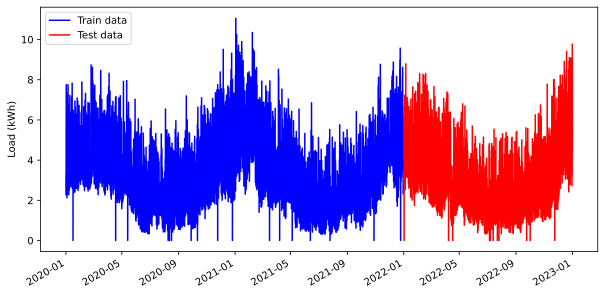

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Read data from CSV files and create a pandas series
csv_files = ["data/electricity_demand_2020.csv", "data/electricity_demand_2021.csv", "data/electricity_demand_2022.csv"]
df_list = []

for file in csv_files:
    temp_df = pd.read_csv(file, index_col=0)
    temp_df.index = pd.to_datetime(temp_df.index, format='%Y-%m-%d %H:%M:%S')
    df_list.append(temp_df)

df = pd.concat(df_list)
load_data = df["Load (kWh)"]

if save_data:
    load_data.to_pickle("data/load_data.pickle")

# Split data into train set and test set
train = load_data[load_data.index.year <= 2021]
test = load_data[load_data.index.year > 2021]

# Plot the data
plt.figure()
train.plot(label="Train data", color="blue")
test.plot(label="Test data", color="red")
plt.ylabel("Load (kWh)")
plt.legend()

if save_figs:
    plt.savefig("figures/load_data.pdf")

plt.show()

## Seasonal Decomposition and Baseline Forecasting

In this section, we create a seasonal baseline model to forecast electricity demand by capturing the periodic patterns in the data using sine and cosine functions with various harmonics. We generate a feature matrix based on daily and annual periods, fit the model to the training data using a least-squares approach, and evaluate the model's performance using the Root Mean Squared Error (RMSE) metric. The visualization of the model's forecasts alongside the actual demand data illustrates its ability to capture the seasonal patterns.

Baseline train RMSE 1.041910060444302
Baseline test RMSE 1.0589568323878649


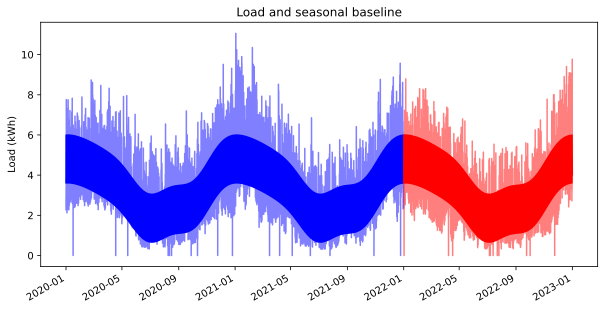

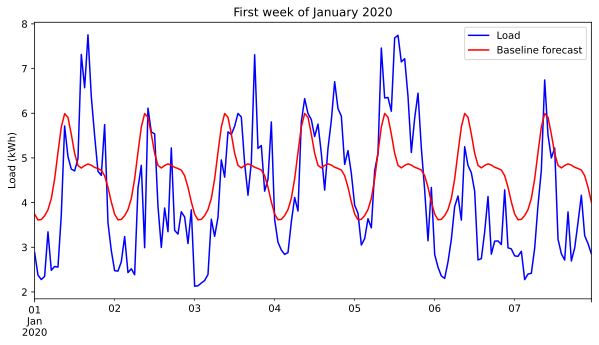

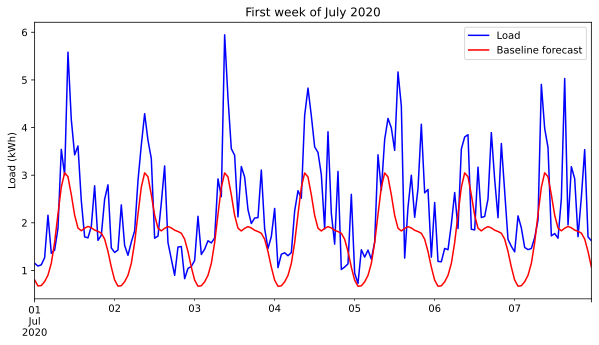

In [3]:
PERIODS = [period / harmonic for harmonic in [1, 2, 3, 4] for period in [24 * 3600, 8760 * 3600]]

def featurize_for_baseline(data, periods):
    seconds = data.index.astype(np.int64) / 1E9
    X = np.zeros((len(seconds), 1 + 2 * len(periods)))
    trig_functions = [np.sin, np.cos]

    for idx, (period, trig) in enumerate([(p, t) for p in periods for t in trig_functions]):
        X[:, idx] = trig(2 * np.pi * seconds / period)

    X[:, -1] = np.ones(len(seconds))
    y = data.values
    return X, y

# def featurize_for_baseline(data, periods):
#     seconds = data.index.astype(np.int64) / 1E9
#     X = np.zeros((len(seconds), 1 + 3 * len(periods)))
#     trig_functions = [np.sin, np.cos]

#     for i, period in enumerate(periods):
#         sine_wave = np.sin(2 * np.pi * seconds / period)
#         cosine_wave = np.cos(2 * np.pi * seconds / period)
        
#         X[:, 3 * i] = sine_wave
#         X[:, 3 * i + 1] = cosine_wave
#         X[:, 3 * i + 2] = sine_wave * cosine_wave

#     X[:, -1] = np.ones(len(seconds))
#     y = data.values
#     return X, y
    

def fit_seasonal_baseline(X, y):
    params = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum_squares(X @ params - y))
    problem = cp.Problem(objective)
    problem.solve()
    return params.value

def predict_with_baseline(X, parameters):
    return X @ parameters


# Featurize and fit the baseline model
Xtr, ytr = featurize_for_baseline(train, PERIODS)
Xte, yte = featurize_for_baseline(test, PERIODS)
baseline_params = fit_seasonal_baseline(Xtr, ytr)

# Make predictions and calculate RMSE
train_baseline = predict_with_baseline(Xtr, baseline_params)
test_baseline = predict_with_baseline(Xte, baseline_params)
def RMSE(array):
    return np.sqrt(np.mean(array**2))
train_rmse = RMSE(train.values - train_baseline)
test_rmse = RMSE(test.values - test_baseline)

print('Baseline train RMSE', train_rmse)
print('Baseline test RMSE', test_rmse)

# Create prediction Series
train_baseline_series = pd.Series(index=train.index, data=train_baseline)
test_baseline_series = pd.Series(index=test.index, data=test_baseline)
baseline = pd.concat([train_baseline_series, test_baseline_series])

if save_data:
    baseline.to_pickle("data/load_baseline.pickle")
    
# Plot load and seasonal baseline
plt.figure()
plt.title("Load and seasonal baseline")
train.plot(alpha=.5, color="blue")
train_baseline_series.plot(alpha=1, color="blue")
test.plot(alpha=.5, color="red")
test_baseline_series.plot(alpha=1, color="red")
plt.ylabel("Load (kWh)")

# Helper function to plot a specific week
def plot_week(start_date, end_date, title):
    plt.figure()
    plt.title(title)
    train.loc[start_date:end_date].plot(label="Load", color="blue")
    train_baseline_series.loc[start_date:end_date].plot(label="Baseline forecast", color="red")
    plt.ylabel("Load (kWh)")
    plt.legend()

# Plot specific weeks
plot_week('2020-01-01', '2020-01-07', "First week of January 2020")
plot_week('2020-07-01', '2020-07-07', "First week of July 2020")


## Autoregressive Model for Residual Error Prediction

In this section, we develop an autoregressive (AR) model to predict the residual errors in the load forecasting. After calculating the residuals by subtracting the seasonal baseline from the actual load, we featurize the residuals by creating lagged values for the train and test datasets. The AR model is then fit to the train dataset, and the predicted residuals are calculated for both the train and test datasets. We also compute and visualize the error covariance matrix to analyze the dependency structure between the errors at different prediction horizons. Finally, we compare the root mean square error (RMSE) of the baseline model with that of the baseline model combined with the AR model at different prediction steps. This allows us to assess the improvement in load forecasting accuracy obtained by incorporating the AR model.

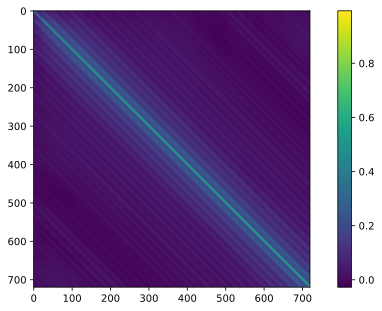

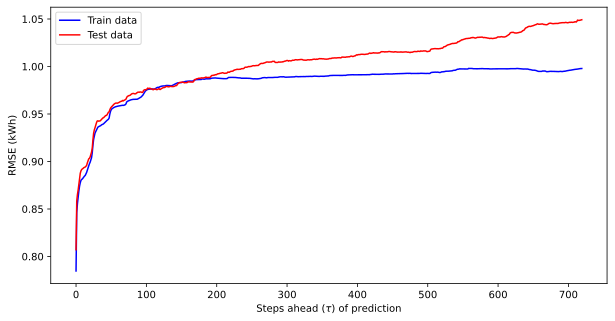

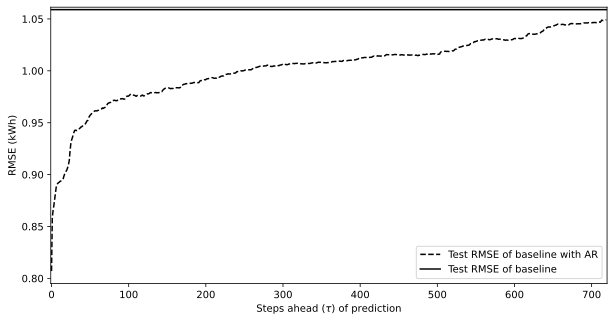

In [4]:
# Calculate residuals
train_residual = train - train_baseline
test_residual = test - test_baseline

M, L = 24*30, 24*30

def featurize_residual(obs, M, L):
    X = np.zeros((len(obs) - M - L+1, M))
    for i in range(M):
        X[:,i] = obs[M-i-1:-L-i]
        
    y = np.zeros((len(obs) - M - L+1, L))
    for i in range(L):
        y[:,i] = obs[M+i:len(obs)+1-L+i]
        
    return X, y

def fit_residual(X, y):
    pinv = np.linalg.inv(X.T @ X) @ X.T
    params = pinv @ y
    return params

# Featurize and fit residuals
Xtr, ytr = featurize_residual(train_residual, M, L)
Xte, yte = featurize_residual(test_residual, M, L)
autoreg_residual_params = fit_residual(Xtr, ytr)

# Save data if needed
if save_data:
    pd.to_pickle(autoreg_residual_params, "data/autoreg_residual_params.pickle")

# Calculate predicted residuals
train_predicted_residuals = Xtr @ autoreg_residual_params
test_predicted_residuals = Xte @ autoreg_residual_params

# Compute and save error covariance matrix
error = (ytr - train_predicted_residuals)
sigma_residual_errors= np.cov(error.T)
if save_data:
    pd.to_pickle(sigma_residual_errors, "data/sigma_residual_errors.pickle")

# Plot error covariance matrix
plt.figure()
plt.imshow(sigma_residual_errors, interpolation='bilinear')
plt.colorbar()

# Define RMSE function for lags
def lag_RMSE(y, hat_y):
    return np.sqrt(np.sum((y - hat_y)**2, 0)/len(y))

# Plot RMSEs for train and test data
plt.figure()
plt.plot(lag_RMSE(ytr, train_predicted_residuals), label='Train data', color="blue")
plt.plot(lag_RMSE(yte, test_predicted_residuals), label='Test data', color="red")
plt.ylabel('RMSE (kWh)')
plt.xlabel('Steps ahead ($\\tau$) of prediction')
plt.legend()

# Plot test RMSEs for baseline with AR and baseline
plt.figure()
plt.plot(lag_RMSE(yte, test_predicted_residuals), 'k--')
plt.axhline(RMSE(test.values - test_baseline), color='k')
plt.legend(['Test RMSE of baseline with AR', 'Test RMSE of baseline'], loc='lower right')
plt.xlabel('Steps ahead ($\\tau$) of prediction')
plt.ylabel('RMSE (kWh)')
plt.xlim([-1,L])

# Save figure if needed
if save_figs:
    plt.savefig("figures/RMSE.pdf")

## Visualizing Electricity Demand Forecasts

In this section, we present a visual comparison of load forecasting results for a specific day in February 2022. Two models are compared: the baseline model and the combined baseline and autoregressive (AR) residual forecast. By plotting the past, future, and prediction series for each model, we can easily assess their performance and identify which approach provides a more accurate forecast for the given time period.

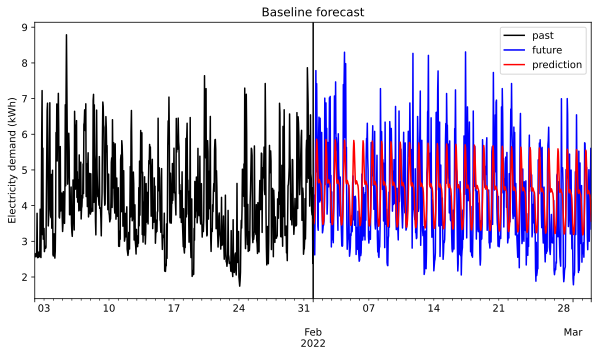

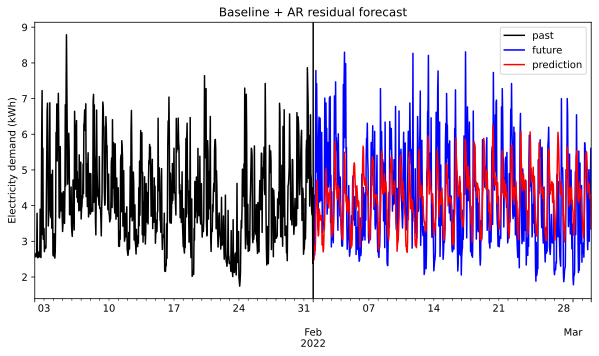

In [5]:
test_day = datetime.datetime(2022, 2, 1)

# Extract past and future data for visualization
past = test[test.index < test_day][-M:]
past_baseline = test_baseline[test.index < test_day][-M:]
future = test[test.index >= test_day][:L]
future_baseline = test_baseline[test.index >= test_day][:L]

# Calculate past residuals and future residual predictions
past_res = past - past_baseline
future_res_prediction = past_res.values @ autoreg_residual_params
future_res = future - future_baseline

# Plot Baseline
plt.figure(figsize=(10, 5))
past.plot(style='k')
future.plot(style='b')
pd.Series(future_baseline, future.index).plot(style='r-')
plt.axvline(test_day, color='k')
plt.ylabel("Electricity demand (kWh)")
plt.legend(labels=['past', 'future', 'prediction'])
plt.title("Baseline forecast")

if save_figs:
    plt.savefig("figures/baseline_forecast.pdf")

# Plot Baseline + AR residual forecast
plt.figure(figsize=(10, 5))
past.plot(style='k')
future.plot(style='b')
pd.Series(future_baseline + future_res_prediction, future.index).plot(style='r-')
plt.axvline(test_day, color='k')
plt.ylabel("Electricity demand (kWh)")
plt.legend(labels=['past', 'future', 'prediction'])
plt.title("Baseline + AR residual forecast")

if save_figs:
    plt.savefig("figures/baseline_AR_residual_forecast.pdf")


## Electricity Price Forecasting

The electricity prices from the utility company are known in advance for the entire year, so the forecast is perfect.

In [6]:
def create_monthly_price_data(year, month, peak_price, off_peak_price):
    # Create a datetime index for the given month
    idx = pd.date_range(start=f'{year}-{month:02d}-01', end=f'{year}-{month:02d}-{pd.Timestamp(year, month, 1).days_in_month} 23:00:00', freq='H')
    # Assign peak and off-peak prices based on the hour of the day
    prices = [off_peak_price if (hour < 6 or hour >= 22) else peak_price for hour in idx.hour]
    # Return a pandas Series with the datetime index and corresponding prices
    return pd.Series(prices, index=idx)

# Generate price data for each month in the given years
price_data_list = [create_monthly_price_data(year, month, 0.3020 if month in [1, 2, 3] else 0.3855, 0.2145 if month in [1, 2, 3] else 0.2980)
                   for year in range(2020, 2023) for month in range(1, 13)]

# Combine the monthly price data into a single pandas Series
price_data = pd.concat(price_data_list)   

# Save the price data if needed
if save_data:
    price_data.to_pickle("data/price_data.pickle")
